# Electricity Consumption Modelling

In this notebook, we will replicate [Electricity consumption modelling: A case of Germany](https://www.sciencedirect.com/science/article/pii/S0264999316300219?casa_token=JpQv-ogScMwAAAAA:CdS1T7TF4l4eqjHNNFrODrvEt8Bp4syfODH7FGdJ4sPTGf4O4hrO6zj8hi-nzhVWUMqEYJa-zSg) by Do, Lin and Molnár (2016) using data for the Netherlands.

## Data and Method

The electricity consumption data was downloaded from [European Network of Transmission System
Operators](https://www.entsoe.eu/). The electricity consumption in the Netherlands for the period of January 2016 to December 2018 was used.

Daily temperature data compiled by [Anika](https://www.kaggle.com/datasets/sinaasappel/historical-weather-in-the-netherlands-19012018) in Kaggle was used to calculate the Heating Degree Days (HDD) variable.

The other variables used were regarding time. They consist of 23 dummies for hour of the day, 6 for day of the week, 11 for month of the year, and two sets of dummies for holidays and the day predecing holidays. 

Industrial production data used in Do, Lin and Molnár was not included in this analysis, as they retroactively use data not yet realeased (e.g. June and July data to estimate May's value). I wanted to see how this model fares as a predicative tool and not only explanatory. Indeed, if you want a prediction of day ahead energy consumption, the only piece of information needed the next day's average temperature.

The following packages will be used through this analysis:

In [141]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import random
import statsmodels.api as sm
import numpy as np
from scipy.stats import kurtosis, skew
import matplotlib.pyplot as plt

In [142]:
# Importing data
data = pd.read_csv('https://raw.githubusercontent.com/CaioVezzaSoares/Electricity-Demand-Modelling/main/data2.txt',
                   sep='\s+')

data['DateShort'] = pd.to_datetime(data['DateShort'],format='%d/%m/%Y')

Electricity consumption is a highly seasonal data, making it a good candidate for forecasting. Below we see the daily and weekly patterns of the data.

Text(0.5, 1.0, 'Electricity Consumption for the First 4 Weeks of 2016')

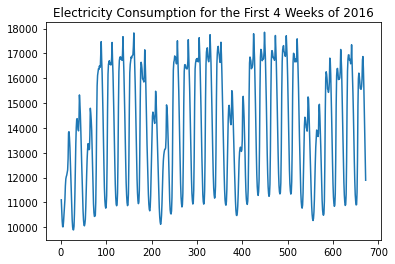

In [143]:
plt.plot(data.iloc[1:673,3])
plt.title('Electricity Consumption for the First 4 Weeks of 2016')

In [145]:
# Creation of dummies
hour = pd.get_dummies(data['TimeFrom'],drop_first=True) # 0:00 dropped

day = pd.get_dummies(data['DateShort'].dt.dayofweek,drop_first=True) # Monday = 0, dropped

month = pd.get_dummies(data['DateShort'].dt.month,drop_first=True) # January dropped

In [146]:
# Merging data and dummies
a = [data,hour,day,month]

df = pd.concat(a,axis=1)

names = ['Date','TimeFrom','TimeTo','Value','Temperature','10:00','11:00','12:00','13:00','14:00','15:00','16:00',
         '17:00','18:00','19:00','1:00','20:00','21:00','22:00','23:00','2:00','3:00','4:00','5:00','6:00','7:00',
         '8:00','9:00','Tue','Wed','Thu','Fri','Sat','Sun','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct',
         'Nov','Dec']

df.columns = names

The national holidays where gathered at [https://www.officeholidays.com](https://www.officeholidays.com/countries/netherlands). The dummies for the following holidays and their preceding day were included: 

|      **Holiday**      | **2016** | **2017** | **2018** |
|:---------------------:|:--------:|:--------:|:--------:|
|   **New Year's Day**  |   1 Jan  |   1 Jan  |   1 Jan  |
|    **Good Friday**    |  25 Mar  |  14 Apr  |  30 Mar  |
|   **Easter Sunday**   |  27 Mar  |  16 Apr  |   1 Apr  |
|   **Easter Monday**   |  28 Mar  |  17 Apr  |   2 Apr  |
|     **King's Day**    |  27 Apr  |  27 Apr  |  27 Apr  |
|   **Liberation Day**  |   5 May  |   5 May  |   5 May  |
|   **Ascension Day**   |   5 May  |  25 May  |  10 May  |
|  **Pentecost Sunday** |  May 15  |   4 Jun  |  20 May  |
|    **Whit Monday**    |  May 16  |   5 Jun  |  21 May  |
|   **Christmas Day**   |  25 Dec  |  25 Dec  |  25 Dec  |
| **St. Stephen's Day** |  26 Dec  |  26 Dec  |  26 Dec  |

In [147]:
holidays = pd.to_datetime(['1/1/2016','3/25/2016','3/27/2016','3/28/2016','4/27/2016','5/5/2016','5/5/2016',
                           '5/15/2016','5/16/2016','12/25/2016','12/26/2016','1/1/2017','4/14/2017','4/16/2017',
                           '4/17/2017','4/27/2017','5/5/2017','5/25/2017','6/4/2017','6/5/2017','12/25/2017',
                           '12/26/2017','1/1/2018','3/30/2018','4/1/2018','4/2/2018','4/27/2018','5/5/2018',
                           '5/10/2018','5/20/2018','5/21/2018','12/25/2018','12/26/2018','01/01/2019'],
                          format='%m/%d/%Y')

offset = holidays + DateOffset(days=-1)

df['Holiday'] = 0
df['Offset'] = 0

for i in holidays:
    df.loc[df['Date'] == i,'Holiday'] = 1

for i in offset:
    df.loc[df['Date'] == i,'Offset'] = 1

The Heating Degree Days (HHD) threshold of 18 used in the original paper was kept, similar latitude and climate of Netherlands and Germany. It is calculated as:

$$HDD=max(T-T_{ref},0)$$

In [148]:
df['HDD'] = df['Temperature'] - 18

for i in range(len(df)):
    if df.loc[i,'HDD'] < 0:
        df.loc[i,'HDD'] = 0

A split of 80/20 will be used to train and test the model, respectively. To ensure that the test data is not concentrated in a particular set of months, the division between the 2 groups will bedone in a randomized fashion. That way, the results are robust to any seasonality in the model's accuracy.

In [149]:
rand = []

for i in range(len(df)):
    rand.append(random.random())

df['Randomizer'] = rand

cutoff = round(len(df)*0.8)

train = df.sort_values(['Randomizer']).iloc[:cutoff].sort_index()

test = df.sort_values(['Randomizer']).iloc[cutoff:].sort_index()

In this notebook we will use the second model from Do, Lin and Molnár, estimating 24 equations for electricity consumption at each hour of the day. The model estimated will be a GLS wih a AR(1) structure of residuals.

$$f_{hour}(t)=a_1+a_2HDD_t+a_3H_t+a_4H_{t-1}+\sum^{6}_{i=1}a_{5i}W_{i,t}+\sum^{12}_{j=2}a_{6j}M_{j,t}+\epsilon_t$$

$$\epsilon_t=\rho\epsilon_{t-1}+v_t$$

In [150]:
models = {}

hours = names[5:28]
hours.append('0:00')

for i in hours:
    ph = train.loc[train['TimeFrom'] == i]
    Y = ph['Value']
    X = ph[ph.columns[28:-1]]
    X = sm.add_constant(X)
    model = sm.GLSAR(Y,X,rho=1)
    models['model_' + str(i)] = model.fit()

C:\Users\Gebruiker\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [151]:
# summary of model for 12:00
models['model_12:00'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           GLSAR Regression Results                           
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.846
Model:                          GLSAR   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     240.0
Date:                Fri, 25 Mar 2022   Prob (F-statistic):               0.00
Time:                        09:55:45   Log-Likelihood:                -7100.0
No. Observations:                 896   AIC:                         1.424e+04
Df Residuals:                     875   BIC:                         1.434e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.65e+04     95.199    173.279      0.000    1.63e+04    1.67e+04
Tue           99.9092     84.974      1.176      0.240     -66.867     266.685
Wed          243.9114     84.425      2.889      0.004      78.213     409.610
Thu          165.1155     84.800      1.947      0.052      -1.320     331.551
Fri           92.1586     84.436      1.091      0.275     -73.563     257.880
Sat        -2095.4851     85.509    -24.506      0.000   -2263.312   -1927.658
Sun        -2779.1069     84.185    -33.012      0.000   -2944.334   -2613.880
Feb         -518.1502    109.891     -4.715      0.000    -733.831    -302.469
Mar        -1561.8337    108.684    -14.370      0.000   -1775.146   -1348.522
Apr        -2499.0237    113.234    -22.070      0.000   -2721.265   -2276.782
May        -2454.4788    111.066    -22.099      0.000   -2672.466   -2236.492
Jun        -2228.1965    109.295    -20.387      0.000   -2442.708   -2013.685
Jul        -2407.2205    116.076    -20.738      0.000   -2635.040   -2179.401
Aug        -2836.0375    111.511    -25.433      0.000   -3054.898   -2617.176
Sep        -2272.2065    109.443    -20.762      0.000   -2487.008   -2057.405
Oct        -2050.1981    112.317    -18.254      0.000   -2270.640   -1829.756
Nov         -582.1450    110.271     -5.279      0.000    -798.571    -365.719
Dec            0.3049    111.496      0.003      0.998    -218.525     219.135
Holiday    -2070.5875    150.629    -13.746      0.000   -2366.224   -1774.951
Offset      -118.0342    140.953     -0.837      0.403    -394.679     158.611
HDD           80.8425     25.943      3.116      0.002      29.926     131.759
==============================================================================
Omnibus:                       26.635   Durbin-Watson:                   1.245
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.293
Skew:                           0.086   Prob(JB):                     1.33e-13
Kurtosis:                       4.249   Cond. No.                         14.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Model Evaluation

We will do 2 types of prediction, in sample and out of sample.

In [152]:
# In sample prediction
in_pred = {}

for i in hours:
    in_pred['pred_' + str(i)] = list(models['model_' + str(i)].predict())

# Out of sample prediction
out_pred = {}

for i in hours:
    ph = test.loc[test['TimeFrom'] == i]
    exog = ph[ph.columns[28:-1]]
    exog = sm.add_constant(exog)
    out_pred['pred_' + str(i)] = list(models['model_' + str(i)].predict(exog))

C:\Users\Gebruiker\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [153]:
# Reconstructing predicted values df
pred_in = pd.DataFrame(columns=['Date','Hour','Value'])

pred_in['Date'] = train['Date']
pred_in['Hour'] = train['TimeFrom']

b = []

for i in pred_in['Hour']:
    b.append(in_pred['pred_'+str(i)].pop(0))

pred_in['Value'] = b

pred_out = pd.DataFrame(columns=['Date','Hour','Value'])

pred_out['Date'] = test['Date']
pred_out['Hour'] = test['TimeFrom']

b = []

for i in pred_out['Hour']:
    b.append(out_pred['pred_'+str(i)].pop(0))

pred_out['Value'] = b

In [154]:
# Model performance statistics

in_error = pred_in['Value'] - train['Value']
out_error = pred_out['Value'] - test['Value']

mae_in = np.sum(np.abs(in_error))/len(pred_in)

mape_in = np.sum(np.abs((in_error)/train['Value']))/len(pred_in)

mae_out = np.sum(np.abs(out_error))/len(pred_out)

mape_out = np.sum(np.abs((out_error)/test['Value']))/len(pred_out)

skew_in = skew(in_error)

kurt_in = kurtosis(in_error,fisher=False)

skew_out = skew(out_error)

kurt_out = kurtosis(out_error,fisher=False)

|              | **In Sample** | **Out of Sample** |
|:------------:|:---------:|:-------------:|
|    **MAE**   |   402.04  |     421.46    |
|   **MAPE**   |   3.08%   |     3.24%     |
| **Skewness** |   -0.32   |     -0.28     |
| **Kurtosis** |    7.47   |      7.29     |

The results show that the model fares relatively well when predicting out of sample, demonstrated by the low MAPE. It fares slightly worse than that of Do, Lin and Molnár, perhaps due to the absense of industrial production data. The low absolute values for skewness of the errors also bodes well for the model, as it indicates that its predictions do not consistently over or underestimate the consumption value.

### Scatter Plots

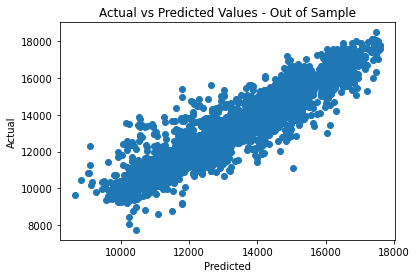

In [163]:
plt.scatter(pred_out['Value'],test['Value'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Actual vs Predicted Values - Out of Sample')
plt.show()

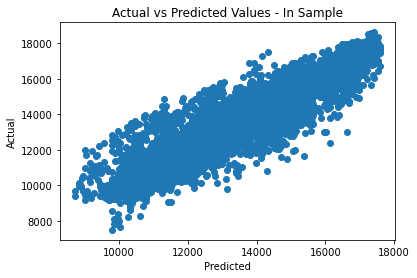

In [165]:
plt.scatter(pred_in['Value'],train['Value'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Actual vs Predicted Values - In Sample')
plt.show()

### MAPE per Hour (percentage points)

In [166]:
# In sample
pd.concat([pred_in['Hour'],np.abs((in_error)/train['Value'])],axis=1).groupby('Hour')['Value'].apply(np.mean)*100

Hour
0:00     2.899435
10:00    3.602105
11:00    3.705745
12:00    3.692867
13:00    3.474944
14:00    3.410812
15:00    3.060450
16:00    2.875055
17:00    2.653244
18:00    2.658640
19:00    2.623863
1:00     2.880077
20:00    2.433910
21:00    2.487354
22:00    2.683017
23:00    2.701985
2:00     2.864700
3:00     2.937914
4:00     3.395321
5:00     3.836007
6:00     3.223984
7:00     3.213778
8:00     3.214114
9:00     3.405805
Name: Value, dtype: float64

In [167]:
# Out of sample
pd.concat([pred_out['Hour'],np.abs((out_error)/test['Value'])],axis=1).groupby('Hour')['Value'].apply(np.mean)*100

Hour
0:00     2.882760
10:00    3.757466
11:00    3.721472
12:00    3.852220
13:00    3.942379
14:00    3.181357
15:00    3.057380
16:00    2.829501
17:00    2.796447
18:00    2.886419
19:00    2.646143
1:00     3.055514
20:00    2.893854
21:00    2.607154
22:00    2.498987
23:00    2.885818
2:00     2.851472
3:00     3.268399
4:00     4.290465
5:00     4.133774
6:00     3.546321
7:00     3.131750
8:00     3.425620
9:00     3.778163
Name: Value, dtype: float64

### MAPE per Weekday (percentage points)

In [107]:
# In sample
pd.concat([pred_in['Date'],np.abs((in_error)/train['Value'])],axis=1).groupby(pred_in['Date'].dt.weekday)['Value'].apply(np.mean)*100

Date
0    3.264526
1    2.822869
2    2.819392
3    2.962533
4    3.153403
5    3.027551
6    3.515378
Name: Value, dtype: float64

In [109]:
# Out of sample
pd.concat([pred_out['Date'],np.abs((out_error)/test['Value'])],axis=1).groupby(pred_out['Date'].dt.weekday)['Value'].apply(np.mean)*100

Date
0    3.530419
1    2.880229
2    2.995659
3    2.868230
4    3.188283
5    3.308894
6    3.886214
Name: Value, dtype: float64

### MAPE per Month (percentage points)

In [110]:
# In sample
pd.concat([pred_in['Date'],np.abs((in_error)/train['Value'])],axis=1).groupby(pred_in['Date'].dt.month)['Value'].apply(np.mean)*100

Date
1     2.180061
2     2.416318
3     4.347873
4     4.591772
5     4.348659
6     2.360473
7     2.263609
8     2.643046
9     1.990529
10    3.317505
11    2.932052
12    3.547548
Name: Value, dtype: float64

In [111]:
# Out of sample
pd.concat([pred_out['Date'],np.abs((out_error)/test['Value'])],axis=1).groupby(pred_out['Date'].dt.month)['Value'].apply(np.mean)*100

Date
1     2.218534
2     2.511823
3     4.368879
4     4.699541
5     4.714108
6     2.357453
7     2.401059
8     2.717325
9     1.998010
10    3.917304
11    3.060966
12    3.611529
Name: Value, dtype: float64

Looking at the MAPE grouped by Hour, Weekday and Month, it seems that the model's precision is not affected by any type of seasonality. In out of sample prediction, we see the largest difference when grouping by month (4.71 (May) - 2.00 (Sep) = 2.71 p.p.). 